# Evaluation of our final model on benchmark RAID

In [1]:
# Global variables setup
import os
import warnings
# Enable parallel computing
os.environ["TOKENIZERS_PARALLELISM"] = "true"
# Suppress warnings
warnings.filterwarnings("ignore", message=".*resume_download.*", category=FutureWarning)
warnings.filterwarnings("ignore", message="torch.utils._pytree._register_pytree_node is deprecated")

In [2]:
# Import other packages
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig
from datasets import load_dataset
from sklearn.model_selection import train_test_split
# import ROC-AUC plot-related packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import auc, roc_curve
# import RAID
import json
from raid import run_detection, run_evaluation
from raid.utils import load_data

In [3]:
# Get the working directories
current_dir = os.getcwd()
model_dir = os.path.join(current_dir, "ML-LoRA-E5/twitter_raid_data/results_LoRA_e5")
data_dir = os.path.join(current_dir, "data/")
eval_dir = os.path.join(data_dir, "evaluation/")

In [20]:
# Import helper functions
model_helpers_path = os.path.join(current_dir, "src/model_helpers.py")
%run $model_helpers_path

data_helpers_path = os.path.join(current_dir, "src/data_helpers.py")
%run $data_helpers_path

evaluate_helpers_path = os.path.join(current_dir, "src/evaluate_helpers.py")
%run $evaluate_helpers_path

## Load the fine-tuned model

In [5]:
# Get the directory of the latest model checkpoints
lora_checkpoints_dir = os.path.join(model_dir, "checkpoint-36480")

In [6]:
# Load the tokenizer and base model 
base_model_name = "intfloat/e5-small" 
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(base_model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-small and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Load the LoRA fine-tuned model
our_model = PeftModel.from_pretrained(base_model, lora_checkpoints_dir)

## 1. Evaluate our detector on a validation set

You may uncomment the code in this section to detect whether your own texts are machine-generated using our model, and compare the predictions with your labels. If you're not given the information if the texts are machine generated, you may continue to Section 2 for the demonstration on predicting unlabaled datasets. We use a subset of RAID training data for demonstration.

### 1.1 Load and prepare the validation set for inference

In [8]:
#train_df = load_data(split="train")

# Load training set 
#train_df = load_dataset("csv", data_files=os.path.join(eval_dir, "RAID_train_df.csv"), split = 'all')
#print(train_df)

Dataset({
    features: ['id', 'adv_source_id', 'source_id', 'model', 'decoding', 'repetition_penalty', 'attack', 'domain', 'title', 'prompt', 'generation'],
    num_rows: 5615820
})


In [9]:
# Process the data set for training, specify your text and label columns
#processed_set = process_data(train_df, "generation", "model")

Creating labels column:   0%|          | 0/5615820 [00:00<?, ? examples/s]

Dropping NAs:   0%|          | 0/5615820 [00:00<?, ? examples/s]

Transforming labels to binary 0/1:   0%|          | 0/5615820 [00:00<?, ? examples/s]

In [10]:
# Print summary of the processed set
#print(processed_set)
#print(is_processed_data(processed_set))
#label_counter(processed_set)

ProcessedData with 5615820 rows
True
Count of human-written entries: 160452
Count of machine-generated entries: 5455368


In [23]:
# Generate a random sample
#excluded_data, processed_subset = train_test_split_equal_class(processed_set, test_size = 1e-2, seed = 620)

In [24]:
#print(processed_subset)

#if not isinstance(processed_subset, pd.DataFrame):
#    processed_subset_df = pd.DataFrame(processed_subset.data)

#train_data_path = os.path.join(eval_dir, "RAID_train_subset.csv")
#processed_subset_df.to_csv(train_data_path, index=False)

ProcessedData with 3208 rows


In [28]:
train_data_path = os.path.join(eval_dir, "RAID_train_subset.csv")
processed_subset = load_dataset("csv", data_files=train_data_path, split='all')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [25]:
# (Optional) Remove columns other than text and labels
reduced_processed_subset = process_data(processed_subset, "text", "labels", reduced=True)
print(reduced_processed_subset)

ProcessedData with 3208 rows


### 1.2 Inference and evaluate the performance

In [26]:
# Inference on data
predicted_probs = inference_model(our_model, reduced_processed_subset, nthreads=8)

Tokenizing data:   0%|          | 0/3208 [00:00<?, ? examples/s]

Processed 100 entries...
Processed 200 entries...
Processed 300 entries...
Processed 400 entries...
Processed 500 entries...
Processed 600 entries...
Processed 700 entries...
Processed 800 entries...
Processed 900 entries...
Processed 1000 entries...
Processed 1100 entries...
Processed 1200 entries...
Processed 1300 entries...
Processed 1400 entries...
Processed 1500 entries...
Processed 1600 entries...
Processed 1700 entries...
Processed 1800 entries...
Processed 1900 entries...
Processed 2000 entries...
Processed 2100 entries...
Processed 2200 entries...
Processed 2300 entries...
Processed 2400 entries...
Processed 2500 entries...
Processed 2600 entries...
Processed 2700 entries...
Processed 2800 entries...
Processed 2900 entries...
Processed 3000 entries...
Processed 3100 entries...
Processed 3200 entries...


In [14]:
# Save predictions to a CSV file
res_csv_path = os.path.join(eval_dir, 'pred_extra_adv_subset.csv')
save_inference_to_csv(predicted_probs, reduced_processed_subset, res_csv_path)

Combined DataFrame saved successfully.


In [15]:
isinstance(predicted_probs.predictions['Predicted_Probs(1)'], list)

True

In [34]:
true_label = reduced_processed_subset['labels']

# Compute metrics
#predicted_label = get_predicted_labels(predicted_probs, 0.6)
res = evaluate_model(predicted_probs, true_label, 0.6)

Overall Metrics given threshold of 0.60
Accuracy: 0.885
Precision: 0.851
Recall: 0.933
False Positive Rate: 0.164
Weighted F1 score: 0.884
Specificity: 0.836
Confusion Matrix:
        Predicted 0  Predicted 1
True 0         1341          263
True 1          107         1497


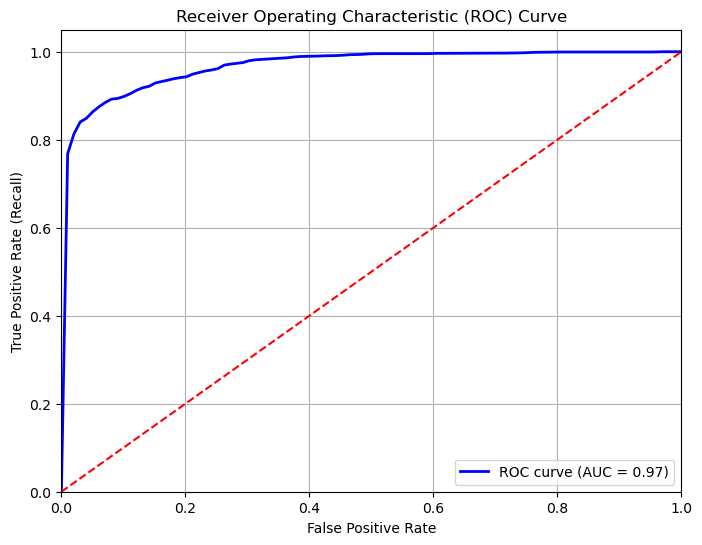

In [36]:
#predicted_probs = predicted_probs.predictions['Predicted_Probs(1)']

# Plot the ROC-AUC curve
fpr, tpr, thres = roc_curve(true_label, predicted_probs)

# Ensure fpr does not contain duplicates
unique_fpr, unique_indices = np.unique(fpr, return_index=True)
unique_tpr = tpr[unique_indices]

roc_auc = auc(unique_fpr, unique_tpr)

# Interpolate to create a smoother curve
interp_fpr = np.linspace(0, 1, 100)  # Create 100 points between 0 and 1 for FPR
interp_tpr = interp1d(unique_fpr, unique_tpr, kind='linear', fill_value='extrapolate')(interp_fpr)

plt.figure(figsize=(8, 6))
plt.plot(interp_fpr, interp_tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random guess)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()

plt.show()

In [37]:
# Read the results as pandas.DataFrame
res_dataframe = read_inference_as_DataFrame(res_csv_path)
print(res_dataframe.head(1))

                                                text  labels  \
0  I've never been happy and I don't think there'...       0   

   Predicted_Probs(1)  
0            0.262028  


In [38]:
# Read the results as datasets.Dataset
res_dataset = read_inference_as_Dataset(res_csv_path)
print(res_dataset[:1])

{'text': ["I've never been happy and I don't think there's anything that could ever make me happy enough for it to be worth suffering I go through every day. I know my family will miss me but they're better off without me. I can't stand living and I don't think there's anything in world for me. Nothing is appealing and my mental illness ruins any good thing that does happen to me. I just don't see reason why I should have to keep living when there's no point to it. I don't understand why people do this. I think the only reason anyone stays alive is because they're too afraid of dying. Happiness is worth nothing when the rest of your time is spend working to pay bills that leave you with barely enough money to eat, let alone pay for any surprise expenses. Every day I get closer and closer to accepting the fact that I was put on this earth to suffer until I finally give in and kill myself. Not even antidepressants can help me."], 'labels': [0], 'Predicted_Probs(1)': [0.26202834]}


## 2. Apply our detector on a test set

This section demonstrates how to use our model to detect the percentage that your texts are machine generated. You can easily use the code below and replace the dataset to yours.

In [9]:
# Load the RAID test data
test_df = load_data(split="test")
#test_df = read_csv(os.path.join(eval_dir, "test_raid_set.csv")

In [10]:
test_ds = Dataset.from_pandas(test_df)
print(isinstance(test_ds, Dataset))
print(test_ds)

True
Dataset({
    features: ['id', 'generation'],
    num_rows: 672000
})


In [11]:
# Generate a random subset for testing
test_subset = test_ds.train_test_split(test_size=0.0001, shuffle=True, seed=12)['test']
test_subset_df = Dataset.to_pandas(test_subset)
print(test_subset_df.head(3))
print(test_subset_df.shape)

                                     id  \
0  c39744bc-bfb4-49b4-8508-4149547be2a5   
1  9c5acac0-def5-44d5-a154-9863a6eab11b   
2  7b8b7930-8aee-4be5-8208-ff41e742d669   

                                          generation  
0  Ingredients:\n- 1 loaf of corn bread, crumbled...  
1  Feker Libi, is a song  by Ehud Banai  and Yeho...  
2  Rebecca L. Gottesman (born 1962) is an America...  
(68, 2)


In [42]:
# Define my detector function for evaluation on RAID test set
def my_detector(texts: list[str], model = our_model) -> list[float]:
    predicted_probs = inference_model(model, texts)
    return predicted_probs.predictions

In [43]:
# Run your detector on the dataset
predictions = run_detection(my_detector, test_subset_df)

Tokenizing data:   0%|          | 0/68 [00:00<?, ? examples/s]

In [44]:
# Extract the predicted probability of machine-generated texts
pred_probs = [item['score']['Predicted_Probs(1)'] for item in predictions]
print(pred_probs[:2])

[0.9554032683372498, 0.9455276727676392]


In [48]:
# Specify the path to your JSON file
file_path = os.path.join(data_dir, "raid_test_predictions/raid_test_subset_predictions.json")

# Save the predictions
with open(file_path, 'w') as f:
    json.dump(predictions, f, indent=4)

In [49]:
# Get predicted labels
pred_label = get_predicted_labels(pred_probs, 0.95)
print(pred_label[:10])

[1, 0, 1, 0, 1, 0, 0, 0, 1, 1]


### 1.3 Load the predictions on the full test set

In [50]:
# Read the JSON file
with open(file_path, 'r') as file:
    pred_test_set = json.load(file)